#  Data Quality Cuts
The purpose of this notebook is to follow Matt's work https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76/data_quality_cuts (login required).

In [2]:
#Imports
import math
import sys
import numpy as np              #Will be used for binning
import pandas as pd             #Will be used for data structuring
import matplotlib.pyplot as plt #Basic plotting library
from matplotlib import cm
from matplotlib import colors
sys.path.append('../')
from R76Tools import *

#Constants
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"

In [3]:
datapath=frittspath
ser=["07220827_1153","07220916_2059","07220917_1039","07220917_2125"]
lab=["0V","-4V","-21V","-65V","-84V","-84V"]
_,z = makechain_list(ser,path=datapath,filters=[fittingfilters,"PTOFamps0"],aliases=calibrationaliases)

## Cuts and aliases

In [4]:
# A lot of this is similar to tutorial replication.
crand=[]; cgoodwalk=[]; cbs=[]
for x in z:
    crand.append(x['EventCategory']==1)
    cgoodwalk.append((x['PCWKr20'] > 0.25e-3)    #The result of ConstFreqRTFTWalk is probably good,
                     & (x['PCWKr20']<0.5e-3)     #based on rise times.
                     & (x['PDWKr20']>0.25e-3)    #This is a quality cut.
                     & (x['PDWKr20']<0.5e-3)
                     & (x['PEWKr20']>0.25e-3)
                     & (x['PEWKr20']<0.5e-3))
    x['PTwid']=(x['PTWKf40']-x['PTWKr40'])*1e6
    x['xdel']=1e6*(x['PEWKr20']-0.5*(x['PCWKr20']+x['PDWKr20']))-1
    x['ydel']=1e6*(0.866*(x['PDWKr20']-x['PCWKr20']))+9
    x['phidel']=[180/np.pi*math.atan2(x['ydel'].array[j],x['xdel'].array[j]) for j in range(len(x['ydel'].array))]
    x['afdel']=1e6*(x['PFWKr20']-x['PAWKr20'])
    x['pt_keV']=7.738820e+07*x['PTOFamps']+1.653756e+13*x['PTOFamps']**2
    x['pt0_keV']=7.738820e+07*x['PTOFamps0']+1.653756e+13*x['PTOFamps0']**2
    x['PSUMbs']=x['PAbs']+x['PBbs']+x['PCbs']+x['PDbs']+x['PEbs']+x['PFbs']
    x['BSel']=x['PSUMbs']-18400
    x['pt_keV_bscorr']=x['pt_keV']/(1.-0.0461538*x['BSel']/165)
    x['pt0_keV_bscorr']=x['pt0_keV']/(1.-0.0461538*x['BSel']/165)
    cbs.append(x['BSel']<1100)
    x['pt_keVee']=14.0821*x['pt_keV_bscorr']/(333.899-x['pt_keV_bscorr'])
    x['pt0_keVee']=14.0821*x['pt0_keV_bscorr']/(333.899-x['pt0_keV_bscorr'])
    x['PTdbs']=(x['PAbspost']-x['PAbs']) + (x['PBbspost']-x['PBbs']) + (x['PCbspost']-x['PCbs']) + (x['PDbspost']-x['PDbs'])\
    + (x['PEbspost']-x['PEbs']) + (x['PFbspost']-x['PFbs'])
    x['PTINTall_PTdbscorr']=x['PTINTall']-(x['PTdbs']<0)*0.5*(x['PTdbs']*4096./x['PFnorm'])

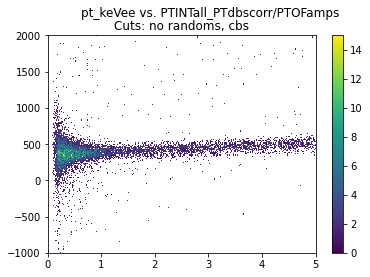

In [5]:
fig, ax = plt.subplots()
binsx=np.linspace(0,5,300)
binsy=np.linspace(-1000,2000,200)
# Setup for white bg
cmap = cm.viridis.copy()
cmap.set_under('w')
h=ax.hist2d(z[1]['pt_keVee'][~crand[1]&cbs[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]],
           bins=[binsx,binsy],cmap=cmap,vmin=1e-10)
fig.colorbar(h[3], ax=ax)
plt.xlim(0,5)
plt.ylim(-1000,2000)
plt.suptitle('pt_keVee vs. PTINTall_PTdbscorr/PTOFamps')
plt.title("Cuts: no randoms, cbs")
plt.show()

In [6]:
# More Cuts
cofintl=[]; cofintt=[]
for x in z:
    cofintl.append((x['PTINTall_PTdbscorr']/x['PTOFamps']>50)&(x['PTINTall_PTdbscorr']/x['PTOFamps']<750))
    cofintt.append((x['PTINTall_PTdbscorr']/x['PTOFamps']>250)&(x['PTINTall_PTdbscorr']/x['PTOFamps']<550))

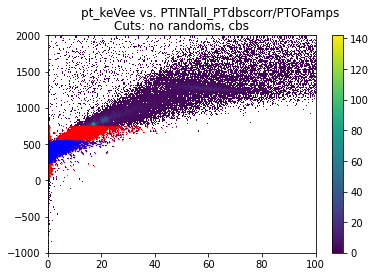

In [7]:
fig, ax = plt.subplots()
binsx=np.linspace(0,100,300)
binsy=np.linspace(-1000,2000,200)
# Setup for white bg
cmap = cm.viridis.copy()
cmap.set_under('w')
h=ax.hist2d(z[1]['pt_keVee'][~crand[1]&cbs[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]],
           bins=[binsx,binsy],cmap=cmap,vmin=1e-10)
fig.colorbar(h[3], ax=ax)
plt.xlim(0,100)
plt.ylim(-1000,2000)
plt.suptitle('pt_keVee vs. PTINTall_PTdbscorr/PTOFamps')
plt.title("Cuts: no randoms, cbs")
plt.scatter(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintl[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]&cofintl[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]&cofintl[1]],
           cmap=cmap,vmin=1e-10,color='r',s=0.1)
plt.scatter(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintt[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]&cofintt[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]&cofintt[1]],
           cmap=cmap,vmin=1e-10,color='blue',s=0.1)
plt.show()

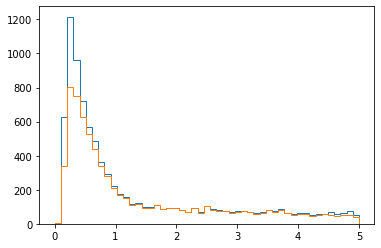

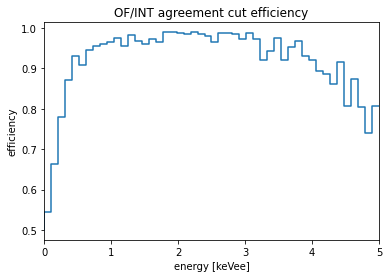

In [21]:
a=plt.hist(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintl[1]],bins=np.linspace(0,5,50),histtype='step')
b=plt.hist(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintt[1]],bins=np.linspace(0,5,50),histtype='step')
plt.show() # Ignore this graph
c=plt.step(np.linspace(0,5,49),b[0]/a[0])
plt.xlim(0,5)
plt.title('OF/INT agreement cut efficiency')
plt.xlabel('energy [keVee]')
plt.ylabel('efficiency')
plt.show()

In [23]:
ngood=len(z[1][~crand[1]&cbs[1]&cofintl[1]&(z[1]['pt_keVee']>0.035)&(x['pt_keVee']<0.5)])
npass=len(z[1][~crand[1]&cbs[1]&cofintt[1]&(z[1]['pt_keVee']>0.035)&(x['pt_keVee']<0.5)])
npass/ngood

0.5388198757763976